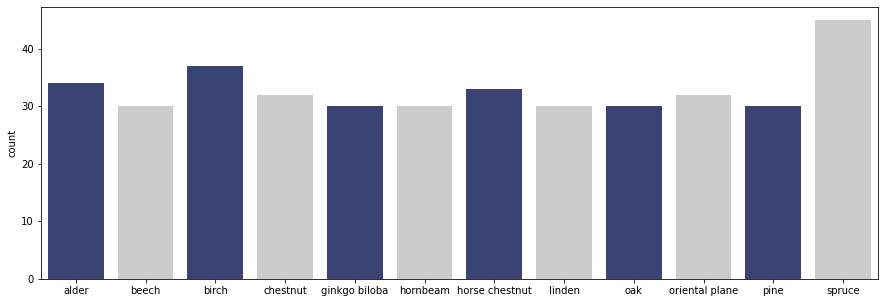

In [22]:
import torch
import torchvision
import torchvision.transforms as transforms
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# initalizing variables
data_dir = '../data/trunk12'
batch_size = 32
split_ratio = 0.9

# specify transformation functions to apply on each image
transform = transforms.Compose([transforms.ToTensor()])

# read images from the dataset directory
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)
total_num = len(dataset.targets)
train_num = int(split_ratio * total_num)
val_num = total_num - train_num

plt.figure(figsize=[15, 5])
p = sns.countplot(dataset.targets, palette=['#2F3C7E', '#CCCCCC'])
p.set_xticklabels(dataset.classes);

In [34]:
# split the images into train and test set
train_dataset, test_dataset = torch.utils.data.random_split(dataset,[train_num, val_num])

# generate a dataloader for the train set
train_loader = torch.utils.data.DataLoader(train_dataset.dataset,
                                            batch_size=batch_size,
                                            shuffle=True)

# generate a dataloader for the test set
test_loader = torch.utils.data.DataLoader(test_dataset.dataset,
                                            batch_size=batch_size,
                                            shuffle=True)

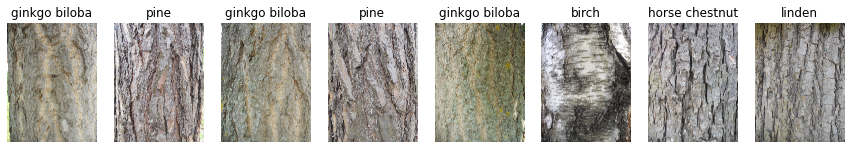

In [24]:
# show multiple examples of images from the training set
train_batch = next(iter(train_loader))

n = 8
plt.figure(figsize=[15,5])
for i in range(n):
    img = train_batch[0][i]
    img = torch.permute(img, (1,2,0))
    target = dataset.classes[train_batch[1][i].item()]
    plt.subplot(1,n,i+1)
    plt.imshow(img)
    plt.title(target)
    plt.axis('off')
plt.show()


In [10]:
#!pip install pyradiomics

In [54]:
import numpy as np
from PIL import Image

# save a mask file
mask = np.ones_like(img) *255
mask[:1,:1,:] = 0
mask = mask.astype(np.uint8)
mask_pil = Image.fromarray(mask)
mask_name = "mask.JPG"
print(np.unique(np.asarray(mask_pil)))
mask_pil.save(mask_name)

[  0 255]


In [35]:
import csv
import numpy as np

# write a csv file with location and label of each image in the train set
pyradiomics_header = ('Image','Mask', 'Label')
m_arr = [mask_name] * len(train_dataset.dataset.imgs)
img_label = train_dataset.dataset.imgs.copy()
rows = [(il[0], m, il[1]) for m, il in zip(m_arr, img_label)]
rows.insert(0, pyradiomics_header)
arr = np.asarray(rows)
np.savetxt('pyradiomics_samples.csv', arr, fmt="%s", delimiter=",")



In [55]:
import radiomics
from radiomics import featureextractor 

print(train_dataset.dataset.imgs[0])
# Instantiate the extractor
extractor = featureextractor.RadiomicsFeatureExtractor()
result = extractor.execute(train_dataset.dataset.imgs[0][0], mask_name, label=255)


('../data/trunk12/alder/1.JPG', 0)


RuntimeError: Exception thrown in SimpleITK LabelStatisticsImageFilter_Execute: /tmp/SimpleITK/Code/Common/include/sitkDualMemberFunctionFactory.hxx:190:
sitk::ERROR: Pixel type: vector of 8-bit unsigned integer is not supported in 2D byN3itk6simple26LabelStatisticsImageFilterE

In [40]:
# Run Pyradiomics on pyradiomics_sample.csv, output to pyradi.csv
!pyradiomics -o pyradi_T1.csv -f csv pyradiomics_samples.csv --label 1

4183.60s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[2022-09-07 06:54:20] E: radiomics.script: Feature extraction failed!
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_python/lib/python3.7/site-packages/radiomics/scripts/segment.py", line 70, in _extractFeatures
    feature_vector.update(extractor.execute(imageFilepath, maskFilepath, label, label_channel))
  File "/home/ubuntu/anaconda3/envs/pytorch_python/lib/python3.7/site-packages/radiomics/featureextractor.py", line 272, in execute
    image, mask = self.loadImage(imageFilepath, maskFilepath, generalInfo, **_settings)
  File "/home/ubuntu/anaconda3/envs/pytorch_python/lib/python3.7/site-packages/radiomics/featureextractor.py", line 385, in loadImage
    mask = imageoperations.getMask(mask, **kwargs)
  File "/home/ubuntu/anaconda3/envs/pytorch_python/lib/python3.7/site-packages/radiomics/imageoperations.py", line 51, in getMask
    raise ValueError('Label (%g) not present in mask. Choose from %s' % (label, labels[labels != 0]))
ValueError: Label (0) n